In [64]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
###############################################################################
########## EVALUATE HURRICANE STATISTICS RELEVANT FOR WIND TURBINE ############
##################### DESIGN FOR A SINGLE HURRICANE  ##########################
###############################################################################

#%% Import modules
import os
import numpy as np   
import matplotlib.pyplot as mpyplot
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
import cmocean
import datetime
import scipy as scipy
from scipy import stats,signal
import pandas
import xarray as xr              


print("done importing modules")


done importing modules


In [65]:
#%% Define file locations
WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_34/"  
# WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_32/"   
# WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_30/"  
# WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_28/"  
# WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_26/"  

# Choose which domain to evaluate
domain = 'd05'

# Whether or not to save figures
saveFig = 'False'

# Decide whether or not to save 1-min wind speed
saveCat = 'False'

# Time series output for each restart
if 'sst_26' in WRF_DIRECTORY:
    restarts = ['timeSeries_08-00__08-05','timeSeries_08-05__08-06']
elif 'sst_28' in WRF_DIRECTORY:
    restarts = ['timeSeries_07-00_07-05','timeSeries_07-05__07-06'] #_newLocs
elif 'sst_30' in WRF_DIRECTORY:
    restarts = ['timeSeries_07-07__07-11','timeSeries_07-11__07-12']
elif 'sst_32' in WRF_DIRECTORY:
    restarts = ['timeSeries_07-00_07-05','timeSeries_07-04_07-05']
elif 'sst_34' in WRF_DIRECTORY:
    restarts = ['timeSeries_07-18__07-22','timeSeries_07-20__07-21']
    
if domain=='d05':
    restarts = restarts[1]
elif domain=='d04':
    restarts = restarts[0]

# Start time for simulations
startTime = np.datetime64('2000-01-01T00:00:00')

# Subsample data to reduce computational time and memory requirements
ss = 1000 # == 1 except for debugging


In [66]:
#%% Extract data for domain size
# Find auxHist files for current domain
entries = os.listdir(WRF_DIRECTORY)
ofInterest = []
for i in np.arange(len(entries)):
    if domain in entries[i]:
        if 'auxH' in entries[i]:
            ofInterest = np.append(ofInterest,i)
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)
print(entries[rndmFromInterest])

# Extract data from auxHist file
ds = xr.open_dataset(WRF_DIRECTORY+str(entries[rndmFromInterest]),decode_times=False)
u = ds['U']
u = np.array(u[0,:,:,:])
v = ds['V']
v = np.array(v[0,:,:,:])
# De-stagger wind speed
u_des = 0.5*(u[:,:,0:np.shape(u)[2]-1]+u[:,:,1:np.shape(u)[2]])
u = 0.0
v_des = 0.5*(v[:,0:np.shape(v)[1]-1,:]+v[:,1:np.shape(v)[1],:])
v = 0.0
# horizontal wind speed
uv = np.sqrt(np.array(u_des)**2 + np.array(v_des)**2)
u_des = 0.0
v_des = 0.0
# Domain dimensions
dx = ds.DX
n_x = dx*np.arange(0,np.shape(uv)[2])
n_y = dx*np.arange(0,np.shape(uv)[1])
uv = uv[0:2,:,:]
ds.close()


auxHist24_d05_2000-01-07_20:01:00


In [67]:
# Time series locations
# Station locations
locs = np.loadtxt(WRF_DIRECTORY +restarts+ '/tslist_d04_d05.txt',skiprows=3,usecols=(2,3)) # [i,j]
name_locs = np.loadtxt(WRF_DIRECTORY +restarts+ '/tslist_d04_d05.txt',skiprows=3,usecols=(1),dtype='U')

# Turbine specifications
D = 178.3 #126
z_hh = 119 #90
rated_ws = 11.4

print("Done extracting data from general variables")


Done extracting data from general variables


In [68]:
#%% Define use for each station
# Define number of "stations" for high-temporal resolution data 
if domain=='d05':
    which_stations = 'hi'
elif domain=='d04':
    which_stations = 'lol'

# Remove time series locations that are not going to be used in analysis
stations = []
for i in np.arange(len(name_locs)):
    if which_stations in name_locs[i]:
        stations = np.append(stations,i)
stations = stations.astype('int')
# stations = stations[::9]
print(stations)
locs = locs[stations]
name_locs = name_locs[stations]
print(name_locs)

# Remove time series locations that are incorrect
if domain=='d05':
    stats = []
    for i in np.arange(len(name_locs)):
        if not locs[i,0] == locs[i,1]:
            stats = np.append(stats,i)       
    stats = stats.astype('int')
    print(stats)
    locs = locs[stats]
    name_locs = name_locs[stats]
    print(name_locs)

locs = locs.astype('int')

[ 17  26  35  44  53  62  71  80  89  98 107 116 125 134 143 152 161 170]
['hi000' 'hi009' 'hi018' 'hi027' 'hi036' 'hi045' 'hi054' 'hi063' 'hi072'
 'hi081' 'hi090' 'hi099' 'hi108' 'hi117' 'hi126' 'hi135' 'hi144' 'hi153']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
['hi000' 'hi009' 'hi018' 'hi027' 'hi036' 'hi045' 'hi054' 'hi063' 'hi072'
 'hi081' 'hi090' 'hi099' 'hi108' 'hi117' 'hi126' 'hi135' 'hi144' 'hi153']


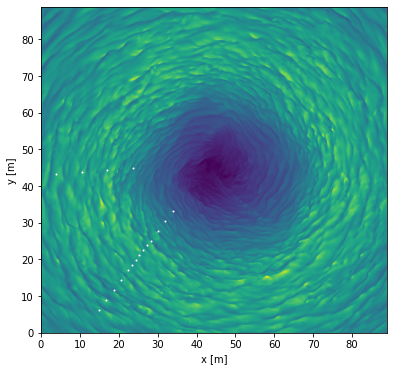

In [69]:
#%% Show relative locations of met tower in the domain
mpyplot.figure(figsize=(6.2,6))
mpyplot.pcolormesh(n_x/1000,n_y/1000,uv[0,:,:])
mpyplot.scatter(n_x[locs[:,0]]/1000,n_y[locs[:,1]]/1000,s=1,color='white')
# mpyplot.scatter(n_x[locs[19,0]]/1000,n_y[locs[19,1]]/1000,s=1,color='red')
# mpyplot.scatter(n_x[locs[26,0]]/1000,n_y[locs[26,1]]/1000,s=1,color='red')
mpyplot.xlabel('x [m]')
mpyplot.ylabel('y [m]')
mpyplot.show()

In [70]:
#%% Extract high-temporal resolution data
# Time arrays
temp = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[-1]+'.'+domain+'.UU',skiprows=1)
init_temp = temp[:,0]
time = temp[::ss,0]*(3600/1) # seconds since start of simulation
time_sinceRst = time - time[0] # seconds since initialization
TIME = startTime + time.astype('timedelta64[s]')

# Height array
GHT = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[0]+'.'+domain+'.PH',skiprows=1)
hgt_agl_stg = GHT[::ss,1:] - GHT[0,1]
hgt_agl_stg = np.mean(hgt_agl_stg,axis=0)
hgt_agl = 0.5*(hgt_agl_stg[1:] + hgt_agl_stg[0:-1])
hgt_agl = np.append(hgt_agl,hgt_agl[-1] + (hgt_agl[-1] - hgt_agl[-2]))

# Initialize arrays [station,valForEachTimeStep,height]
U = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
V = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
# W = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
# theta = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])

# Extract data for each station
for i_s in np.arange(0,len(locs)):
    # Load data
    tempU = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.UU',skiprows=1)
    tempV = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.VV',skiprows=1)
#     tempW = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.WW',skiprows=1)
#     tempT = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.TH',skiprows=1)
    # Save data
    U[i_s,:,:] = tempU[:np.shape(init_temp)[0]:ss,1:]
    V[i_s,:,:] = tempV[:np.shape(init_temp)[0]:ss,1:]
#     W[i_s,:,:] = tempW[:np.shape(init_temp)[0]:ss,1:]
#     theta[i_s,:,:] = tempT[:np.shape(init_temp)[0]:ss,1:]

    print('Done with %i out of %i' % (i_s,len(locs)-1))

# Release memory
tempU = 0.0
tempV = 0.0
# tempW = 0.0

# Calculate horizontal wind speed
UV = np.sqrt(U**2 + V**2)

print("Done extracting high-temporal resolution data")


Done with 0 out of 17
Done with 1 out of 17
Done with 2 out of 17
Done with 3 out of 17
Done with 4 out of 17
Done with 5 out of 17
Done with 6 out of 17
Done with 7 out of 17
Done with 8 out of 17
Done with 9 out of 17
Done with 10 out of 17
Done with 11 out of 17
Done with 12 out of 17
Done with 13 out of 17
Done with 14 out of 17
Done with 15 out of 17
Done with 16 out of 17
Done with 17 out of 17
Done extracting high-temporal resolution data


In [71]:
#%% Calculate wind direction using time series output
wDir = np.zeros(np.shape(U))

for i_s in np.arange(np.shape(locs)[0]):
    for iz in np.arange(len(hgt_agl)):
        uu = np.zeros_like(U[i_s,:,iz]) + U[i_s,:,iz]
        vv = np.zeros_like(V[i_s,:,iz]) + V[i_s,:,iz]
#         vv[vv==0] = 0.1
#         wDir[i_s,:,iz] = np.arctan(uu/vv)*180/np.pi
        wDir[i_s,:,iz] = np.arctan2(vv,uu)*180/np.pi
        
uu = 0
vv = 0
U = 0.0
V = 0.0

# Wind direction in engineering coordinates (from [1,0] vector )
wDir[wDir<0] = (180 + wDir[wDir<0]) + 180


In [72]:
#%% Load data for temporal evolution of hurricane center for each height
arr_x = np.loadtxt(WRF_DIRECTORY +restarts+ '/center_x.txt',skiprows=1,delimiter=',')
arr_y = np.loadtxt(WRF_DIRECTORY +restarts+ '/center_y.txt',skiprows=1,delimiter=',')

time_center = arr_x[:,0]
time_center_sinceRst = time_center - time_center[0]
center_x = arr_x[:,1:]
center_y = arr_y[:,1:]
    

Text(0, 0.5, 'r [km]')

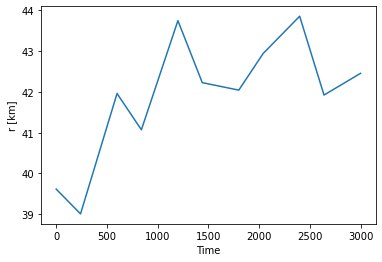

In [73]:
#%% Estimate temporal evolution of radial distance for each time series location at one height
radial_dist = np.zeros([len(time_center),np.shape(locs)[0]])
iz = 0

for it in np.arange(len(time_center)):
    radial_dist[it,:] = ((n_x[locs[:,0]] - center_x[it,iz])**2 + (n_y[locs[:,1]] - center_y[it,iz])**2)**0.5

# Time series of radial distance for a given met-tower at one height
mpyplot.figure()
mpyplot.plot(time_center_sinceRst,radial_dist[:,-1]/1000)
mpyplot.xlabel('Time')
mpyplot.ylabel('r [km]')

Text(0, 0.5, 'r [km]')

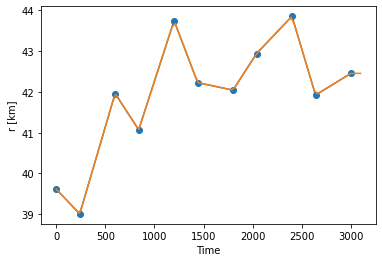

In [74]:
#%% Interpolate data in time to match time series output
# Interpolate center of hurricane at each height
center = np.zeros([len(time_sinceRst),np.shape(center_x)[1],2]) # [time, height, x or y center location]
for i_z in np.arange(np.shape(center_x)[1]):
    center[:,i_z,0] = np.interp(time_sinceRst,time_center_sinceRst,center_x[:,i_z])
    center[:,i_z,1] = np.interp(time_sinceRst,time_center_sinceRst,center_y[:,i_z])
    
# Interpolate radial distance from center of hurricane at z=10m
r_fromC = np.zeros([len(time_sinceRst),np.shape(locs)[0]]) # [time, station, radial distance]
for i_s in np.arange(np.shape(locs)[0]):
    r_fromC[:,i_s] = np.interp(time_sinceRst,time_center_sinceRst,radial_dist[:,i_s])
    
# Time series of radial distance for a given met-tower at one height
mpyplot.figure()
mpyplot.plot(time_center_sinceRst,radial_dist[:,-1]/1000,'-o')
mpyplot.plot(time_sinceRst,r_fromC[:,-1]/1000)
mpyplot.xlabel('Time')
mpyplot.ylabel('r [km]')

Text(0, 0.5, 'Maximum instantaneous U [m/s]')

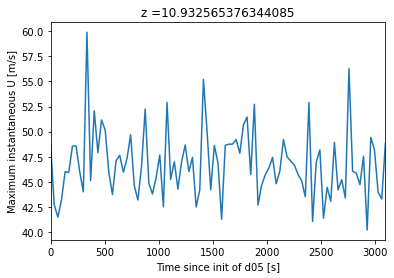

In [75]:
#%% Time series of maximum instantaneous wind speed at a given vertical level
col = mpyplot.cm.viridis(np.linspace(0,1,len(locs)))
iz = 0

mpyplot.figure()
mpyplot.title('z ='+str(hgt_agl[iz]))
mpyplot.plot(time_sinceRst,np.max(np.abs(UV[:,:,iz]),axis=0))
mpyplot.xlim(time_sinceRst[0],time_sinceRst[-1])
mpyplot.xlabel('Time since init of ' + str(domain)+' [s]')
mpyplot.ylabel('Maximum instantaneous U [m/s]')

## Get 10-min and 3-sec statistics

In [76]:
#%% Define moving average function
def moving_average(x, n,mode):
    mv_avg = np.zeros(np.shape(x))
    temp = np.convolve(x, np.ones(n), mode) / n #full valid same
    if mode=='valid':
        mv_avg[0:np.shape(x)[0]-n+1] = temp
        # Fill edges with data
        mv_avg[-n:] = np.sum(x[-n:])/n
    elif mode=='same':
        mv_avg = temp
        mv_avg[0:n] = np.sum(x[0:n])/n
        mv_avg[-n:] = np.sum(x[-n:])/n
    
    return mv_avg

#%% Define moving median function
from scipy.ndimage import median_filter
def moving_median(x, n):
    return median_filter(x[x != 0], n)


In [78]:
#%% Mean time step in simulations
dt = np.mean(time[1:] - time[0:-1])


In [79]:
#%% Estimate 10-min horizontal wind speed statistics
window_10m = 10*60 # [s]
n_window_10m = int(window_10m/dt)

# Height of interest
zzz = z_hh
i_zzz = np.argmin(np.abs(hgt_agl - zzz))

avgUV_10m = np.zeros(np.shape(UV))

for i_s in np.arange(np.shape(UV)[0]): # station
    for iz in np.arange(np.shape(UV)[2]): # height
        avgUV_10m[i_s,:,iz] = moving_average(UV[i_s,:,iz],n_window_10m,'same')

avgUV_10m_hh = avgUV_10m[:,:,i_zzz]

print('Done estimating %f second statistics' % window_10m)

Done estimating 600.000000 second statistics


In [80]:
#%% Estimate perturbation quantities
pertUV = UV[:,:,i_zzz] - avgUV_10m_hh

# Detrend perturbations
pertUV = scipy.signal.detrend(pertUV,axis=1)

# Variance oh horizontal velocity
var_UV_hh = pertUV*pertUV

print('Done estimating perturbation quantities')

Done estimating perturbation quantities


In [82]:
#%% Estimate 3-sec horizontal wind speed statistics
window_3s = 3 # [s]
n_window_3s = int(window_3s/dt)

avgUV_3s_hh = np.zeros(np.shape(UV)[0:2])

# Height of interest
zzz = z_hh
i_zzz = np.argmin(np.abs(hgt_agl - zzz))

avgUV_3s = np.zeros(np.shape(UV))

for i_s in np.arange(np.shape(UV)[0]): # station
    for iz in np.arange(np.shape(UV)[2]): # height
        avgUV_3s[i_s,:,iz] = moving_average(UV[i_s,:,iz],n_window_3s,'same')
        
avgUV_3s_hh = avgUV_3s[:,:,i_zzz]

print('Done estimating %f second statistics' % window_3s)

Done estimating 400.000000 second statistics


In [83]:
# Define eyewall radius based on 3D fields
if 'sst_26' in WRF_DIRECTORY:
    r_eye = 13805
    label = '26 C'
elif 'sst_28' in WRF_DIRECTORY:
    r_eye = 21300
    label = '28 C'
elif 'sst_30' in WRF_DIRECTORY:
    r_eye = 20333
    label = '30 C'
elif 'sst_32' in WRF_DIRECTORY:
    r_eye = 27055
    label = '32 C'
elif 'sst_34' in WRF_DIRECTORY:
    r_eye = 33638.915
    label = '34 C'


print('Eyewall radius at r = %f km' % (r_eye/1000))            


Eyewall radius at r = 33.638915 km


## Radial locations of interest

In [84]:
# Radial locations of interest
r_r = np.arange(0.8,1.3,0.1)
r_t0 = radial_dist[0,:]
i_rrr = (r_t0>r_r[0]*r_eye) & (r_t0<=r_r[-1]*r_eye)

## Fit 3-sec and 10-min wind profiles to power law

Done estimating fit of 3-sec wind profile to power-law wind profile
Done estimating fit of 10-min wind profile to power-law wind profile


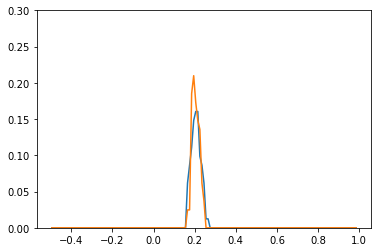

In [85]:
# Fit hurricane profiles to power law
from scipy.optimize import curve_fit

def powLaw(z_z,alpha):
    u_o = u_curr;
    UUU = u_o*((z_z/z_hh)**alpha)
    return UUU



# Fit 3-sec propfiles
iz_max = np.argmin(np.abs(hgt_agl - (z_hh + 0.6*D)))
temp_arr_3s = avgUV_3s[i_rrr,:,:]
alpha_fit_3s = np.zeros(np.shape(temp_arr_3s)[0:2]) + np.nan
for i_s in np.arange(np.shape(alpha_fit_3s)[0]):
    for it in np.arange(0,np.shape(temp_arr_3s)[1],n_window_3s):
        u_curr = temp_arr_3s[i_s,it,i_zzz]
        popt, pcov = curve_fit(powLaw, hgt_agl[0:iz_max], temp_arr_3s[i_s,it,0:iz_max])
        alpha_fit_3s[i_s,it] = popt[0]

print("Done estimating fit of 3-sec wind profile to power-law wind profile")

# Fit 10-min propfiles
temp_arr_10m = avgUV_10m[i_rrr,:,:]
alpha_fit_10m = np.zeros(np.shape(temp_arr_10m)[0:2]) + np.nan
for i_s in np.arange(np.shape(alpha_fit_10m)[0]):
    for it in np.arange(0,np.shape(temp_arr_10m)[1],n_window_3s):
        u_curr = temp_arr_10m[i_s,it,i_zzz]
        popt, pcov = curve_fit(powLaw, hgt_agl[0:iz_max], temp_arr_10m[i_s,it,0:iz_max])
        alpha_fit_10m[i_s,it] = popt[0]

print("Done estimating fit of 10-min wind profile to power-law wind profile")

# Bins alpha
bins_alpha = np.arange(-0.5,1,0.01)

# Histograms
hist_3s_alpha = np.histogram(np.reshape(alpha_fit_3s,np.prod(np.shape(alpha_fit_3s))),bins=bins_alpha)
hist_3s_alpha = hist_3s_alpha[0]/np.nansum(hist_3s_alpha[0])

hist_10m_alpha = np.histogram(np.reshape(alpha_fit_10m,np.prod(np.shape(alpha_fit_3s))),bins=bins_alpha)
hist_10m_alpha = hist_10m_alpha[0]/np.nansum(hist_10m_alpha[0])

bins_alpha = 0.5*(bins_alpha[1:] + bins_alpha[0:-1])

# Figure
mpyplot.figure()
mpyplot.plot(bins_alpha,hist_3s_alpha)
mpyplot.plot(bins_alpha,hist_10m_alpha)
mpyplot.ylim(0,0.3)

#%% Distributions of alpha
saveAlpha_distr = 'False'
if saveAlpha_distr == 'True':
    fName = 'alpha_distr.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(bins_alpha)):
            strr = ''
            strr = str(bins_alpha[i])  + ',' + str(hist_3s_alpha[i]) + ',' + str(hist_10m_alpha[i])
            f.write(strr)
            f.write('\n')

## Wind direction statistics

In [87]:
#%% Define functions that estimate change in wind direction

# Define function that estimates temporal change in wind direction for one height
def delta_wDir_oneZ(wDir1,wDir2):
    delta = np.abs(wDir1 - wDir2)
    
    if delta>180:
        delta = 360 - delta
        
    return delta



# Define function that estimates vertical change in wind direction for one time
def delta_wDir_twoZ(wDir1,wDir2,z1,z2,normalize):
    wDir_low = wDir1
    wDir_high = wDir2
    
    delta = 0
    
    if np.abs(wDir_high-wDir_low)<=0:#180:
        delta = wDir_high-wDir_low
    else:
        a = np.abs(wDir_high-wDir_low)
        b = np.abs(360-a)
        delta = np.min([a,b])
        
        if (wDir_high>=0) & (wDir_high<=90):
            if (wDir_low>=270) & (wDir_low<=360):
                delta = 1*delta
        elif (wDir_high>=270) & (wDir_high<=360):
            if (wDir_low>=0) & (wDir_low<=90):
                delta = -1*delta
    
    dz = z2-z1
    if dz>0:
        if normalize=='True':
            delta = delta/dz
        
    return delta


In [88]:
#%% Estimate 10-sec yaw misalignment
window_6s = 10 # [s]
n_window_6s = int(window_6s/dt)

# Height of interest
zzz = z_hh
i_zzz = np.argmin(np.abs(hgt_agl - zzz))

# Temporal change in wind direction over time window    
yaw_mis = np.zeros(np.shape(wDir)[0:2]) + np.nan
for i_s in np.arange(np.shape(locs)[0]):
    for i_t in np.arange(np.shape(wDir)[1]-n_window_6s):
        # Yaw-misalignment
        tempMax = 0
        mxx = np.max(wDir[i_s,i_t:i_t+n_window_6s,i_zzz])
        mnn = np.min(wDir[i_s,i_t:i_t+n_window_6s,i_zzz])
        tempMax = delta_wDir_oneZ(mxx,mnn)
        yaw_mis[i_s,i_t] = tempMax
    # print('Done with station ' + str(i_s) + ' of ' + str(np.shape(locs)[0]-1))

print('Done estimating yaw-misalignment for %f second statistics' % window_6s)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# Define function that estimates vertical change in wind direction for one time
#%% Decide whether or not to normalize veer
normalize = 'True'
print('normalize == ' + normalize)

t_veer = 10 # [s]
n_window_veer = int(t_veer/dt) # [number of time steps]

# Heights covering turbine rotor layer
z_bott = z_hh - 0.5*D
z_top = z_hh + 0.5*D
iz_b = np.argmin(np.abs(hgt_agl - z_bott))
iz_t = np.argmin(np.abs(hgt_agl - z_top))

# Estimate veer over turbine rotor layer
veer_RL = np.zeros(np.shape(wDir)[0:2])
for i_s in np.arange(np.shape(locs)[0]):
    # Time-averaged wind direction at each height
    wDir_bott =  moving_median(wDir[i_s,:,iz_b],n_window_veer)
    wDir_top =  moving_median(wDir[i_s,:,iz_t],n_window_veer)
    for i_t in np.arange(len(time_sinceRst)-1):
        veer_RL[i_s,i_t] = delta_wDir_twoZ(wDir_bott[i_t],wDir_top[i_t],hgt_agl[iz_b],hgt_agl[iz_t],normalize)
    print('Done with station ' + str(i_s) + ' of ' + str(np.shape(locs)[0]-1))

## Get radial distribution of wind veer over turbine rotor layer
# Flatten arrays
r_flat = r_fromC.flatten()
veer_RL_flat  = np.transpose(veer_RL).flatten()
# Sort arrays
i_sort = np.argsort(r_flat)
r_sort = r_flat[i_sort]
veer_RL_flat = veer_RL_flat[i_sort]
# Average veer, ith percentile and maximum veer for each radial location
alpha_CI = 0.05
i_th = 1-(0.5*alpha_CI)
ii_th = 0.5*alpha_CI
r_incr = np.arange(np.min(r_fromC),np.max(r_fromC),1000)
mean_veer_RL_r = np.zeros(len(r_incr)-1)
max_veer_RL_r = np.zeros(len(r_incr)-1)
ith_perc_veer_RL_r = np.zeros(len(r_incr)-1)
iith_perc_veer_RL_r = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = veer_RL_flat[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
    temp_arr = np.abs(temp_arr)
    mean_veer_RL_r[i_r] = np.median(temp_arr)
    ith_perc_veer_RL_r[i_r] = np.percentile(temp_arr,i_th*100)
    iith_perc_veer_RL_r[i_r] = np.percentile(temp_arr,ii_th*100)
    max_veer_RL_r[i_r] = np.max(temp_arr)
    
r_incr = 0.5*(r_incr[1:] + r_incr[0:-1])

mpyplot.figure()
mpyplot.plot(r_sort[::50]/1000,np.abs(veer_RL_flat[::50]),label=str(t_veer)+'-sec')
mpyplot.plot(r_incr/1000,mean_veer_RL_r,label='Median')
mpyplot.plot(r_incr/1000,ith_perc_veer_RL_r,label=str(int(i_th*100))+'th percentile')
mpyplot.plot(r_incr/1000,max_veer_RL_r,label='Max')
mpyplot.xlabel('r [km]')
if normalize=='True':
    mpyplot.ylabel(r'$\Delta \phi$ rotor layer [deg/m]')
else:
    mpyplot.ylabel(r'$\Delta \phi$ rotor layer [deg]')
mpyplot.xlim(np.min(r_incr/1000),np.max(r_incr/1000))
mpyplot.legend()
if saveFig=='True':
    mpyplot.savefig(WRF_DIRECTORY + "dirShear_RL.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()    

# Time series of wid direction at two heights
mpyplot.figure()
mpyplot.plot(time_sinceRst,wDir_bott)
mpyplot.plot(time_sinceRst,wDir_top)


#%% Save wind veer radial distributions
saveVeer_distr = 'False'
if saveVeer_distr == 'True':
    fName = 'veer_Rdistr.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(r_incr)):
            strr = str(r_incr[i]) + ',' + str(mean_veer_RL_r[i]) + ',' + str(ith_perc_veer_RL_r[i])+ ',' + str(iith_perc_veer_RL_r[i]) + ',' + str(max_veer_RL_r[i])
                
            f.write(strr)
            f.write('\n')
            

In [43]:
#%% Estimate wind speed shear over turbine rotor layer using 10-min wind speed
z_bott = z_hh - 0.5*D
z_top = z_hh + 0.5*D
iz_b = np.argmin(np.abs(hgt_agl - z_bott))
iz_t = np.argmin(np.abs(hgt_agl - z_top))

sp_shear = np.zeros(np.shape(wDir)[0:2]) + np.nan
for i_s in np.arange(np.shape(locs)[0]):
    uv_top = moving_average(UV[i_s,:,iz_t],n_window_6s,'same')
    uv_bot = moving_average(UV[i_s,:,iz_b],n_window_6s,'same')
    sp_shear[i_s,:] = (uv_top - uv_bot)/(hgt_agl[iz_t] - hgt_agl[iz_b])

print('Done estimating shear')

Done estimating shear using 6-sec wind speed


## Statistics relevant for IEC standards

In [46]:
#%% Choose radial increments for radial distributions
dr_incr = 1000

# Radial locations for all met-towers
r_flat = r_fromC.flatten()
i_sort = np.argsort(r_flat)
r_sort = r_flat[i_sort]

# Radial increments
r_incr = np.arange(np.min(r_fromC),np.max(r_fromC),dr_incr)


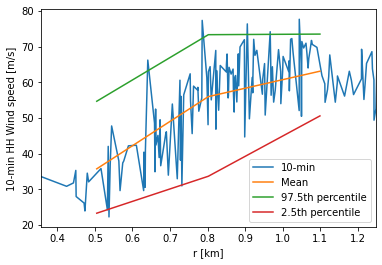

In [47]:
#%% Find radial distribution of 10-min hub-height wind speed
## Prepare arrays
# Get radial distribution of 10-min wind speed gust at hub height
avgUV_10m_hh_flat  = np.transpose(avgUV_10m_hh).flatten()
# Sort arrays
avgUV_10m_hh_flat = avgUV_10m_hh_flat[i_sort]

## Get average 10-min gust on dr_incr radial increments and i-th percentile
alpha_CI = 0.05
i_th = 1-(0.5*alpha_CI)
ii_th = 0.5*alpha_CI
mean_uv_10_r = np.zeros(len(r_incr)-1)
ith_perc_uv_10_r = np.zeros(len(r_incr)-1)
iith_perc_uv_10_r = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = avgUV_10m_hh_flat[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
    mean_uv_10_r[i_r] = np.mean(temp_arr)
    ith_perc_uv_10_r[i_r] = np.percentile(temp_arr,i_th*100)
    iith_perc_uv_10_r[i_r] = np.percentile(temp_arr,ii_th*100)
r_incr_ = 0.5*(r_incr[1:] + r_incr[0:-1])

mpyplot.figure()
mpyplot.plot(r_sort[::int(10/ss)+1]/r_eye,avgUV_10m_hh_flat[::int(10/ss)+1],label='10-min')
mpyplot.plot(r_incr_/r_eye,mean_uv_10_r,label='Mean')
mpyplot.plot(r_incr_/r_eye,ith_perc_uv_10_r,label=str(np.round(i_th*100,2))+'th percentile')
mpyplot.plot(r_incr_/r_eye,iith_perc_uv_10_r,label=str(np.round(ii_th*100,2))+'th percentile')
mpyplot.xlabel('r [km]')
mpyplot.ylabel('10-min HH Wind speed [m/s]')
mpyplot.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
mpyplot.legend()
mpyplot.show()

In [23]:
np.sum(avgUV_10m_hh_flat>57)/len(avgUV_10m_hh_flat)

0.6138878176802978

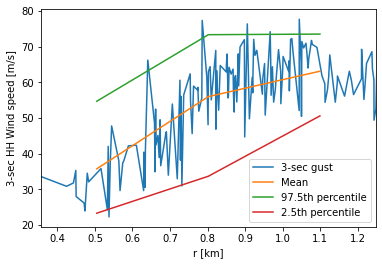

In [48]:
#%% Find radial distribution of 3-sec hub-height wind speed
## Prepare arrays
# Get radial distribution of 3-sec wind speed gust at hub height
avgUV_3s_hh_flat  = np.transpose(avgUV_3s_hh).flatten()
# Sort arrays
avgUV_3s_hh_flat = avgUV_3s_hh_flat[i_sort]

## Get average 3-sec gust on dr_incr radial increments and i-th percentile
alpha_CI = 0.05
i_th = 1-(0.5*alpha_CI)
ii_th = 0.5*alpha_CI
mean_uv_3s_r = np.zeros(len(r_incr)-1)
ith_perc_uv_3s_r = np.zeros(len(r_incr)-1)
iith_perc_uv_3s_r = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = avgUV_3s_hh_flat[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
    mean_uv_3s_r[i_r] = np.mean(temp_arr)
    ith_perc_uv_3s_r[i_r] = np.percentile(temp_arr,i_th*100)
    iith_perc_uv_3s_r[i_r] = np.percentile(temp_arr,ii_th*100)
r_incr_ = 0.5*(r_incr[1:] + r_incr[0:-1])

mpyplot.figure()
mpyplot.plot(r_sort[::int(10/ss)+1]/r_eye,avgUV_3s_hh_flat[::int(10/ss)+1],label='3-sec gust')
mpyplot.plot(r_incr_/r_eye,mean_uv_3s_r,label='Mean')
mpyplot.plot(r_incr_/r_eye,ith_perc_uv_3s_r,label=str(np.round(i_th*100,2))+'th percentile')
mpyplot.plot(r_incr_/r_eye,iith_perc_uv_3s_r,label=str(np.round(ii_th*100,2))+'th percentile')
mpyplot.xlabel('r [km]')
mpyplot.ylabel('3-sec HH Wind speed [m/s]')
mpyplot.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
mpyplot.legend()
mpyplot.show()

In [26]:
np.sum(avgUV_3s_hh_flat>0.8*1.4*57)/len(avgUV_3s_hh_flat)

0.28870484186283174

<ipython-input-49-c8064fe98762>:30: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  mpyplot.ylim(0,np.nanmax(yaw_mis_flat))


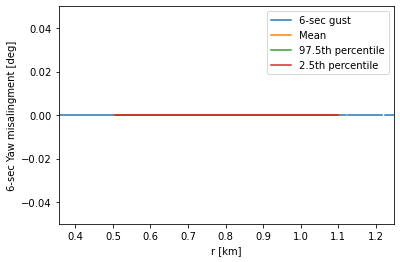

In [49]:
#%% Find radial distribution of yaw-misalignment
## Prepare arrays
yaw_mis_flat  = np.transpose(yaw_mis).flatten()
# Sort arrays
yaw_mis_flat = yaw_mis_flat[i_sort]

## Get average 6-sec gust on dr_incr radial increments and i-th percentile
alpha_CI = 0.05
i_th = 1-(0.5*alpha_CI)
ii_th = 0.5*alpha_CI
mean_yawMis_6s_r = np.zeros(len(r_incr)-1)
ith_perc_yawMis_6s_r = np.zeros(len(r_incr)-1)
iith_perc_yawMis_6s_r = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = yaw_mis_flat[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    mean_yawMis_6s_r[i_r] = np.nanmean(temp_arr)
    ith_perc_yawMis_6s_r[i_r] = np.percentile(temp_arr,i_th*100)
    iith_perc_yawMis_6s_r[i_r] = np.percentile(temp_arr,ii_th*100)
r_incr_ = 0.5*(r_incr[1:] + r_incr[0:-1])

mpyplot.figure()
mpyplot.plot(r_sort[::int(10/ss)+1]/r_eye,yaw_mis_flat[::int(10/ss)+1],label='6-sec gust')
mpyplot.plot(r_incr_/r_eye,mean_yawMis_6s_r,label='Mean')
mpyplot.plot(r_incr_/r_eye,ith_perc_yawMis_6s_r,label=str(np.round(i_th*100,2))+'th percentile')
mpyplot.plot(r_incr_/r_eye,iith_perc_yawMis_6s_r,label=str(np.round(ii_th*100,2))+'th percentile')
mpyplot.xlabel('r [km]')
mpyplot.ylabel('6-sec Yaw misalingment [deg]')
mpyplot.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
mpyplot.ylim(0,np.nanmax(yaw_mis_flat))
mpyplot.legend()
mpyplot.show()


# Distribution of max yaw misalignment at multiple radial locations
yaw_incr = np.arange(0,40,0.5)
distr_yawMis_r = np.zeros([len(r_incr)-1,len(yaw_incr)-1])
for ir in np.arange(len(r_incr)-1):
    temp_arr = yaw_mis_flat[(r_sort>r_incr[ir]) & ((r_sort<=r_incr[ir+1]))]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    distr_yawMis_r[ir,:] = np.histogram(temp_arr[temp_arr>0],bins=yaw_incr)[0]
bins_plot = 0.5*(yaw_incr[1:] + yaw_incr[0:-1])


#%% Save yaw misalignment distributions
saveYawMis_distr = 'False'
if saveYawMis_distr == 'True':
    norm_distr_yawMis_r = np.zeros_like(distr_yawMis_r) + distr_yawMis_r
    for ii in np.arange(len(distr_yawMis_r[:,0])):
        norm_distr_yawMis_r[ii,:] = norm_distr_yawMis_r[ii,:]/np.sum(norm_distr_yawMis_r[ii,:])
    fName = 'yawMis_distr.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(bins_plot)+1):
            strr = ''
            if i==0:
                for ir in np.arange(len(r_incr)-1):
                    rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
                    if ir == 0:
                        strr = strr + str(rrr)
                    else:
                        strr = strr + ',' + str(rrr)
            else:
                strr = strr + str(bins_plot[i-1]) 
                for rr in np.arange(len(distr_yawMis_r[:,0])):
                    strr = strr + ',' + str(norm_distr_yawMis_r[rr,i-1]) # yawMis,pdf_r_i
            f.write(strr)
            f.write('\n')
            


In [50]:
#%% Distribution of standard deviation at multiple radial locations
# Get radial distribution of 3-sec wind speed gust at hub height
var_UV_hh_flat  = np.transpose(var_UV_hh).flatten()
# Sort arrays
var_UV_hh_flat = var_UV_hh_flat[i_sort]
std_UV_hh_flat = var_UV_hh_flat**0.5


std_incr = np.arange(0,40,0.5)
distr_std_r = np.zeros([len(r_incr)-1,len(yaw_incr)-1])
for ir in np.arange(len(r_incr)-1):
    temp_arr = std_UV_hh_flat[(r_sort>r_incr[ir]) & ((r_sort<=r_incr[ir+1]))]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    distr_std_r[ir,:] = np.histogram(temp_arr[temp_arr>0],bins=std_incr)[0]
bins_plot = 0.5*(yaw_incr[1:] + yaw_incr[0:-1])

#%% Save yaw misalignment distributions
saveStd_distr = 'False'
if saveStd_distr == 'True':
    norm_distr_std_r = np.zeros_like(distr_std_r) + distr_std_r
    for ii in np.arange(len(distr_std_r[:,0])):
        norm_distr_std_r[ii,:] = norm_distr_std_r[ii,:]/np.sum(norm_distr_std_r[ii,:])
    fName = 'std_distr.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(bins_plot)+1):
            strr = ''
            if i==0:
                for ir in np.arange(len(r_incr)-1):
                    rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
                    if ir == 0:
                        strr = strr + str(rrr)
                    else:
                        strr = strr + ',' + str(rrr)
            else:
                strr = strr + str(bins_plot[i-1]) 
                for rr in np.arange(len(distr_std_r[:,0])):
                    strr = strr + ',' + str(norm_distr_std_r[rr,i-1]) # yawMis,pdf_r_i
            f.write(strr)
            f.write('\n')
            

In [52]:
#%% One-dimensional histogram for 3-sec gust and 10-min wind speed
edges_gust = np.arange(10,100,1) #np.arange(np.min(avgUV_3s_hh),np.max(avgUV_3s_hh),1)
edges_mean = np.arange(10,80,1) #np.arange(np.min(avgUV_10m_hh),np.max(avgUV_10m_hh),1)

hist_gust_stats = np.zeros([np.shape(locs)[0],len(edges_gust)-1]) + np.nan
hist_mean_stats = np.zeros([np.shape(locs)[0],len(edges_mean)-1]) + np.nan

for i_s in np.arange(np.shape(locs)[0]):
    hist_gust_stats[i_s,:] = np.histogram(avgUV_3s_hh[i_s,:],bins=edges_gust)[0]
    hist_mean_stats[i_s,:] = np.histogram(avgUV_10m_hh[i_s,:],bins=edges_mean)[0]
    
r0 = 0.85*r_eye-1000
r1 = 1.25*r_eye-1000
stat0 = np.argmin(np.abs(radial_dist[0,:] - r0)) # 33000
stat1 = np.argmin(np.abs(radial_dist[0,:] - r1)) # 33000
statss = np.array([stat0,stat1])
statss = np.sort(statss)
print(str(0.8*r_eye)+','+str(1.2*r_eye))
print(radial_dist[0,stat0])
print(radial_dist[0,stat1])

hist_gust_stats = np.nansum(hist_gust_stats[statss[0]:statss[1],:],axis=0)
hist_mean_stats = np.nansum(hist_mean_stats[statss[0]:statss[1],:],axis=0)

save_oneDimProb = 'False';
if save_oneDimProb=='True':
    import pickle
    fName_Prob_mean = 'prob_mean.pkl'
    fName_Prob_gust = 'prob_gust.pkl'
    fName_edges_gust = 'edges_gust2.pkl'
    fName_edges_mean = 'edges_mean2.pkl'
    with open(WRF_DIRECTORY + fName_Prob_mean, 'wb') as file:
        pickle.dump(hist_mean_stats, file)
    with open(WRF_DIRECTORY + fName_Prob_gust, 'wb') as file:
        pickle.dump(hist_gust_stats, file)
    with open(WRF_DIRECTORY + fName_edges_gust, 'wb') as file:
        pickle.dump(edges_gust, file)
    with open(WRF_DIRECTORY + fName_edges_mean, 'wb') as file:
        pickle.dump(edges_mean, file)


26911.132,40366.698
27660.719441603465
39613.7913651421


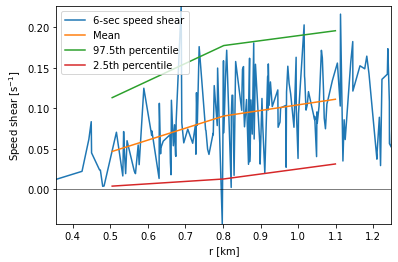

In [53]:
#%% Find radial distribution of speed shear
## Prepare arrays
sp_shear_flat  = np.transpose(sp_shear).flatten()
# Sort arrays
sp_shear_flat = sp_shear_flat[i_sort]

## Get average 6-sec gust on dr_incr radial increments and i-th percentile
alpha_CI = 0.05
i_th = 1-(0.5*alpha_CI)
ii_th = 0.5*alpha_CI
mean_sp_shear_r = np.zeros(len(r_incr)-1)
ith_perc_sp_shear_r = np.zeros(len(r_incr)-1)
iith_perc_sp_shear_r = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = sp_shear_flat[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    mean_sp_shear_r[i_r] = np.nanmean(temp_arr)
    ith_perc_sp_shear_r[i_r] = np.percentile(temp_arr,i_th*100)
    iith_perc_sp_shear_r[i_r] = np.percentile(temp_arr,ii_th*100)
r_incr_ = 0.5*(r_incr[1:] + r_incr[0:-1])

mpyplot.figure()
mpyplot.plot(r_sort[::int(10/ss)+1]/r_eye,sp_shear_flat[::int(10/ss)+1],label='6-sec speed shear')
mpyplot.plot(r_incr_/r_eye,mean_sp_shear_r,label='Mean')
mpyplot.plot(r_incr_/r_eye,ith_perc_sp_shear_r,label=str(np.round(i_th*100,2))+'th percentile')
mpyplot.plot(r_incr_/r_eye,iith_perc_sp_shear_r,label=str(np.round(ii_th*100,2))+'th percentile')
mpyplot.plot([0,100],[0,0],'-k',linewidth=0.5)
mpyplot.xlabel('r [km]')
mpyplot.ylabel('Speed shear [s$^{-1}$]')
mpyplot.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
mpyplot.ylim(np.nanmin(sp_shear_flat),np.nanmax(sp_shear_flat))
mpyplot.legend()
mpyplot.show()


No handles with labels found to put in legend.


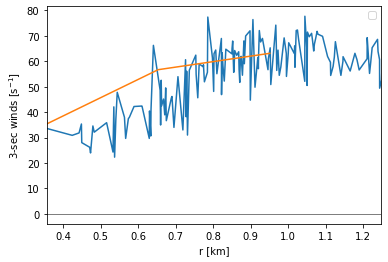

In [54]:
#%% Median 3-sec wind speed profiles at different radial locations
## Release memory
UV = 0.0
pertUV = 0.0
var_UV_hh = 0.0
wDir = 0.0


## Prepare arrays
almFlat_3s  = np.transpose(avgUV_3s,axes=(1,0,2)).reshape(np.product(np.shape(avgUV_3s)[0:2]),np.shape(avgUV_3s)[-1])
almFlat_10m  = np.transpose(avgUV_10m,axes=(1,0,2)).reshape(np.product(np.shape(avgUV_10m)[0:2]),np.shape(avgUV_10m)[-1])
# Sort arrays
almFlat_3s = almFlat_3s[i_sort,:]
almFlat_10m = almFlat_10m[i_sort,:]

## Get median for each incremetal radial location for 3-sec winds
i_median_r_3s = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = almFlat_3s[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1])),i_zzz]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    # Find median in array
    med = np.nanmedian(temp_arr)
    # Find value that is closest to median for this radial location
    i_temp = np.argmin(np.abs(temp_arr - med))
    val_temp = temp_arr[i_temp]
    # Find index of median in almFlat_3s array
    i_median_r_3s[i_r] = np.nanargmin(np.abs(val_temp - almFlat_3s[:,i_zzz]))
i_median_r_3s = i_median_r_3s.astype('int')   
# Check that I found the medioan
mpyplot.figure()
mpyplot.plot(r_sort[::int(10/ss)+1]/r_eye,almFlat_3s[::int(10/ss)+1,i_zzz])
mpyplot.plot(r_incr[0:-1]/r_eye,almFlat_3s[i_median_r_3s,i_zzz])
mpyplot.plot([0,100],[0,0],'-k',linewidth=0.5)
mpyplot.xlabel('r [km]')
mpyplot.ylabel('3-sec winds [s$^{-1}$]')
mpyplot.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
# mpyplot.ylim(np.nanmin(sp_shear_flat),np.nanmax(sp_shear_flat))
mpyplot.legend()
mpyplot.show()

#%% Save wind speed profiles
saveProfs_r = 'False'
if saveProfs_r == 'True':
    ## 3-sec winds
    fName = '3-sec_profiles.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(hgt_agl)+1):
            strr = ''
            # Show the radial location for each profile
            if i==0:
                for ir in np.arange(len(r_incr)-1):
                    rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
                    if ir == 0:
                        strr = strr + str(rrr)
                    else:
                        strr = strr + ',' + str(rrr)
            else:
                # Save the velocity profile
                strr = strr + str(hgt_agl[i-1]) 
                for rr in np.arange(len(r_incr)-1):
                    strr = strr + ',' + str(almFlat_3s[i_median_r_3s[rr],i-1]) # z,U(r0),U(r1),... 
            f.write(strr)
            f.write('\n')


In [55]:
#%% Median 10-min wind speed profiles at different radial locations
# Release memory
almFlat_3s = 0.0

## Prepare arrays
almFlat_10m  = np.transpose(avgUV_10m,axes=(1,0,2)).reshape(np.product(np.shape(avgUV_10m)[0:2]),np.shape(avgUV_10m)[-1])
# Sort arrays
almFlat_10m = almFlat_10m[i_sort,:]

## Get median for each incremetal radial location for 10-min winds
i_median_r_10m = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = almFlat_10m[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1])),i_zzz]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    # Find median in array
    med = np.nanmedian(temp_arr)
    # Find value that is closest to median for this radial location
    i_temp = np.argmin(np.abs(temp_arr - med))
    val_temp = temp_arr[i_temp]
    # Find index of median in almFlat_3s array
    i_median_r_10m[i_r] = np.nanargmin(np.abs(val_temp - almFlat_10m[:,i_zzz]))
i_median_r_10m = i_median_r_10m.astype('int')   

#%% Save wind speed profiles
saveProfs_r = 'False'
if saveProfs_r == 'True':
    ## 10-min winds
    fName = '10-min_profiles.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(hgt_agl)+1):
            strr = ''
            # Show the radial location for each profile
            if i==0:
                for ir in np.arange(len(r_incr)-1):
                    rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
                    if ir == 0:
                        strr = strr + str(rrr)
                    else:
                        strr = strr + ',' + str(rrr)
            else:
                # Save the velocity profile
                strr = strr + str(hgt_agl[i-1]) 
                for rr in np.arange(len(r_incr)-1):
                    strr = strr + ',' + str(almFlat_10m[i_median_r_10m[rr],i-1]) # z,U(r0),U(r1),... 
            f.write(strr)
            f.write('\n')
            
            

In [56]:
#%% Radial locations of interest to evaluate IEC models
r_r = np.arange(0.8,1.3,0.1)

# Indices for each radial location
i_radLocs = np.zeros(len(r_r))
for ir in np.arange(len(r_r)):
    i_radLocs[ir] = np.argmin(np.abs(r_incr_ - r_r[ir]*r_eye))

i_radLocs = i_radLocs.astype('int')

print(r_incr_[i_radLocs]/r_eye)

[0.80213412 0.80213412 1.09940887 1.09940887 1.09940887]


## Evaluate DLC 6-7 for wind speed and gust

In [57]:
#%% Define functions to estiamte atmospheric conditions during extreme events (IEC models)

def EWM_turbulent(u_ref,u_hub,z_rotor,z_hub):
    # 10-min hub-height wind speed for 50-year and 1-year recurrence
    u_50 = u_ref*((z_rotor/z_hub)**0.11);
    u_1 = 0.8*u_50;
    # Turbulence standard deviation
    std = 0.11*u_hub
    return [u_50,u_1,std]

def EWM_steady(u_ref,z_rotor,z_hub):
    # 3-sec hub-height wind speed for 50-year and 1-year recurrence
    u_e50 = 1.4*u_ref*((z_rotor/z_hub)**0.11);
    u_e1 = 0.8*u_e50;
    return [u_e50,u_e1]

def NTM(u_hub,i_ref):
    b = 5.6
    # Standard deviation of streamwise wind
    std = i_ref*(0.75*u_hub + b)
    return std


In [58]:
#%% DLC 6
# Reference conditions for turbine class
I_ref = 0.16 # Class A turbine
U_ref = np.array([50]) # Class I turbine


z_TL = np.linspace(z_hh-0.5*D,z_hh+0.5*D,15)
i_z_IEC = np.argmin(np.abs(z_TL - z_hh))

## 6.1a
# EWM turbulent wind model
# U_hub = 0.95*U_ref
U_hub = 0.95*U_ref
U_50_61a,U_1_61a,STD_61a = EWM_turbulent(U_ref,U_hub,z_TL,z_hh)
print('10-min extreme wind speed is %f (%f) for 50-year and 1-year recurrence' % (U_50_61a[i_z_IEC],U_1_61a[i_z_IEC]))
print('Turbulence standard deviation is %f' % (STD_61a))

## 6.1b
# EWM steady wind model
# U_hub = U_e50
U_e50_61b,U_e1_61b = EWM_steady(U_ref,z_TL,z_hh)
print('3-sec extreme wind speed is %f (%f) for 50-year and 1-year recurrence' % (U_e50_61b[i_z_IEC],U_e1_61b[i_z_IEC]))

## 6.4
# Normal turbulence model
# U_hub < 0.7*U_ref
U_hub = 0.7*U_ref
STD_64 = NTM(U_hub,I_ref)
print('Turbulence standard deviation is %f' % (STD_64))



10-min extreme wind speed is 50.000000 (40.000000) for 50-year and 1-year recurrence
Turbulence standard deviation is 5.225000
3-sec extreme wind speed is 70.000000 (56.000000) for 50-year and 1-year recurrence
Turbulence standard deviation is 5.096000


## Compare IEC standards with hurricane simulations

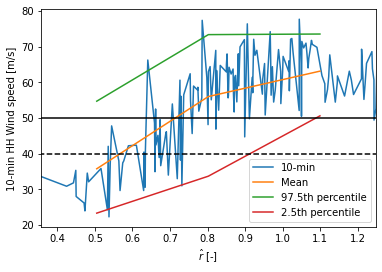

In [59]:
#%% Compare 10-min extreme winds with radial distribution of 10-min winds
mpyplot.figure()
mpyplot.plot(r_sort[::int(10/ss)+1]/r_eye,avgUV_10m_hh_flat[::int(10/ss)+1],label='10-min')
mpyplot.plot(r_incr_/r_eye,mean_uv_10_r,label='Mean')
mpyplot.plot(r_incr_/r_eye,ith_perc_uv_10_r,label=str(np.round(i_th*100,2))+'th percentile')
mpyplot.plot(r_incr_/r_eye,iith_perc_uv_10_r,label=str(np.round(ii_th*100,2))+'th percentile')
mpyplot.plot([0,3],[U_50_61a[i_z_IEC],U_50_61a[i_z_IEC]],'-k')
mpyplot.plot([0,3],[U_1_61a[i_z_IEC],U_1_61a[i_z_IEC]],'--k')
mpyplot.xlabel(r'$\hat{r}$ [-]')
mpyplot.ylabel('10-min HH Wind speed [m/s]')
mpyplot.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
mpyplot.legend()
mpyplot.show()


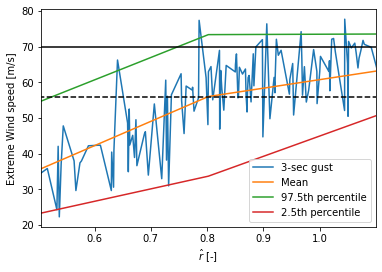

In [60]:
#%% Compare 3-sec extreme winds with radial distribution of 3-sec winds
mpyplot.figure()
mpyplot.plot(r_sort[::int(10/ss)+1]/r_eye,avgUV_3s_hh_flat[::int(10/ss)+1],label='3-sec gust')
mpyplot.plot(r_incr_/r_eye,mean_uv_3s_r,label='Mean')
mpyplot.plot(r_incr_/r_eye,ith_perc_uv_3s_r,label=str(np.round(i_th*100,2))+'th percentile')
mpyplot.plot(r_incr_/r_eye,iith_perc_uv_3s_r,label=str(np.round(ii_th*100,2))+'th percentile')
mpyplot.plot([0,3],[U_e50_61b[i_z_IEC],U_e50_61b[i_z_IEC]],'-k')
mpyplot.plot([0,3],[U_e1_61b[i_z_IEC],U_e1_61b[i_z_IEC]],'--k')
mpyplot.xlabel(r'$\hat{r}$ [-]')
mpyplot.ylabel('Extreme Wind speed [m/s]')
mpyplot.xlim(np.min(r_incr_/r_eye),np.max(r_incr_/r_eye))
mpyplot.legend()
mpyplot.show()

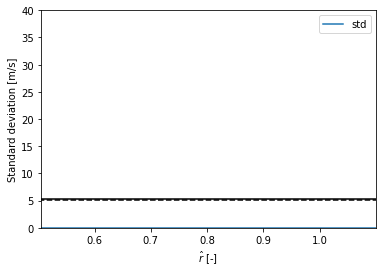

In [62]:
#%% Compare standard deviation of hub-height winds with hurricane
mpyplot.figure()
mpyplot.plot(r_sort[::int(10/ss)+1]/r_eye,(var_UV_hh_flat[::int(10/ss)+1])**0.5,label='std')
mpyplot.plot([0,3],[STD_61a,STD_61a],'-k')
mpyplot.plot([0,3],[STD_64,STD_64],'--k')
mpyplot.xlabel(r'$\hat{r}$ [-]')
mpyplot.ylabel('Standard deviation [m/s]')
mpyplot.xlim(np.min(r_incr_/r_eye),np.max(r_incr_/r_eye))
mpyplot.ylim(0,40)
mpyplot.legend()
mpyplot.show()